# **Pre-processing & Feature Engineering**

Load Libraries

In [208]:
# File upload (Google Colab)
from google.colab import files

# Basic data handling
import pandas as pd
import numpy as np
from collections import Counter  # For encoding support

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Train-test split
from sklearn.model_selection import train_test_split

# Collinearity and statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Unsupervised feature engineering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Supervised feature selection (planned)
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# System / warning handling
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)



Load Dataset

In [159]:
# Upload the CSV file
uploaded = files.upload()

# Load the CSV into a pandas DataFrame
df = pd.read_csv(next(iter(uploaded)))

# Show the first few rows
df.head()


Saving preprocessing_dataset.csv to preprocessing_dataset (6).csv


,company,amount,round,completed,federal_fund_effective_rate,10yr_treasury_yield,lead_investor_this_round,lead_investor_co_type,stage_at_funding,primary_ta,indications,primary_tech,company_type,location,business_model,public_private,total_raised_all_rounds
0,Alba Therapeutics Corp.,30.0,Series A,8/23/2005,3.49,NaN,SV Health Investors LLP,Fin - VC / Private Equity,Phase III,Autoimmune,Gastrointestinal (GI) dysfunction,Small Molecule,Private,Maryland,Platform and Own Product Development,Private,30.0
1,Allozyne Inc. (MedImmune),3.5,Series A,12/6/2005,3.97,4.49,NaN,NaN,Phase III,Autoimmune,Rheumatoid Arthritis; Psoriasis; Crohn’s Disea...,Antibody,Private,Washington,Late Stage Dev and Commercialization,Private,34.0
2,Allozyne Inc. (MedImmune),30.0,Series B,10/26/2007,4.80,4.41,MPM BioImpact (aka MPM Capital),Fin - VC / Private Equity,Phase III,Autoimmune,Rheumatoid Arthritis; Psoriasis; Crohn’s Disea...,Antibody,Private,Washington,Late Stage Dev and Commercialization,Private,34.0
3,Anthera Pharmaceuticals Inc.,17.1,Common,3/2/2010,0.14,3.62,NaN,NaN,Phase II,Autoimmune,Pancreatic insufficiency,Small Molecule,Public Small,California,Platform and Own Product Development,Public,336.0
4,Senesco Technologies Inc.,10.3,Convertible Notes,3/29/2010,0.16,3.88,NaN,NaN,Preclinical / IND,Autoimmune,Multiple myeloma (MM),Antibody,Public Small,Massachusetts,Platform and Own Product Development,Public,12.0


**Additional Cleaning Post EDA**

Drop columns with high missingness and high collinearity

In [160]:
# Drop columns with high missingness and high collinearity
columns_to_drop = [
    'lead_investor_this_round',
    'lead_investor_co_type',
    '10yr_treasury_yield',
    'total_raised_all_rounds'
]

df.drop(columns=columns_to_drop, inplace=True)

# Confirm the drops
print("Remaining columns after dropping:")
print(df.columns)



Remaining columns after dropping:
Index(['company', 'amount', 'round', 'completed',
       'federal_fund_effective_rate', 'stage_at_funding', 'primary_ta',
       'indications', 'primary_tech', 'company_type', 'location',
       'business_model', 'public_private'],
      dtype='object')


Drop unique identifier

In [161]:
# Drop company column because it is a unique identifier
df = df.drop('company', axis=1)


Drop Public Large companies

In [162]:
# Drop rows where company_type is 'Public Large'
df = df[df['company_type'] != 'Public Large']

# Confirm the filter worked
print("Rows remaining after removing 'Public Large' companies:", len(df))
print(df['company_type'].value_counts())


Rows remaining after removing 'Public Large' companies: 9386
company_type
Public Small     5241
Private          2972
Public Medium    1173
Name: count, dtype: int64


Convert the completed column to display year only

In [163]:
# Convert to datetime and extract year
df['completed'] = pd.to_datetime(df['completed'], errors='coerce')
df['completed_year'] = df['completed'].dt.year

# Drop the original column
df.drop('completed', axis=1, inplace=True)

# Check that it worked
print("Completed column removed:", 'completed' not in df.columns)
print("Sample of completed_year values:")
print(df['completed_year'].head())


Completed column removed: True
Sample of completed_year values:
0    2005.0
1    2005.0
2    2007.0
3    2010.0
4    2010.0
Name: completed_year, dtype: float64


**Train-test split**

Calculate ideal split ratio based on number of predictors

In [164]:
# Dr. Geists' helper code:
def calc_split_ratio(df, p=None):

    # Set p to the number of predictors if not provided
    if p is None:
        p = df.shape[1] - 1  # The number of features (predictors),
                             # assuming last column is target

    # Calculate ideal number for testing set
    test_N = (1 / np.sqrt(p)) * len(df)

    # Calculate testing proportion
    test_prop = round(test_N / len(df), 2)

    # Calculate training proportion
    train_prop = 1 - test_prop

    # Print the results
    print(f"The ideal split ratio is {train_prop}:{test_prop} training:testing")

    # Return the size of the training set proportion
    return train_prop


In [165]:
# Set number of predictors
p = df.shape[1] - 1

# Call the function
train_prop = calc_split_ratio(df, p)


The ideal split ratio is 0.7:0.3 training:testing


Split into training and testing sets

In [166]:
# Separate features and target
X = df.drop('amount', axis=1)
y = df['amount']

# Use the ratio calculated above
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_prop, random_state=42)

# Confirm sizes
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 6570
Testing set size: 2816


**Encode Categorical Variables**

In [ ]:
# Helper function: keep top-N categories, collapse others into "Other"
def collapse_categories(series, top_n, other_name="Other"):
    top_categories = series.value_counts().nlargest(top_n).index
    return series.apply(lambda x: x if x in top_categories else other_name)

# Helper function: count encode a single column
def count_encode(train_col, test_col):
    counts = train_col.value_counts()
    train_encoded = train_col.map(counts)
    test_encoded = test_col.map(counts).fillna(0)
    return train_encoded, test_encoded

# Start encoding
def encode_data(train_df, test_df):
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()

    # Count encoding for specified variables
    count_vars_with_topN = {
        'stage_at_funding': 6,
        'primary_ta': None,
        'indications': 10,
        'primary_tech': 19,
        'location': None
    }

    # --- Collapse & encode ---
    # stage_at_funding
    train_encoded['stage_at_funding'] = collapse_categories(train_encoded['stage_at_funding'], 6, 'Other')
    test_encoded['stage_at_funding'] = collapse_categories(test_encoded['stage_at_funding'], 6, 'Other')
    train_encoded['stage_at_funding'], test_encoded['stage_at_funding'] = count_encode(train_encoded['stage_at_funding'], test_encoded['stage_at_funding'])

    # primary_ta
    ta_other = ['Other', 'Not Applicable', 'Unknown']
    train_encoded['primary_ta'] = train_encoded['primary_ta'].replace(ta_other, 'TA Other')
    test_encoded['primary_ta'] = test_encoded['primary_ta'].replace(ta_other, 'TA Other')
    train_encoded['primary_ta'], test_encoded['primary_ta'] = count_encode(train_encoded['primary_ta'], test_encoded['primary_ta'])

    # indications
    train_encoded['indications'] = collapse_categories(train_encoded['indications'], 10, 'Other')
    test_encoded['indications'] = collapse_categories(test_encoded['indications'], 10, 'Other')
    train_encoded['indications'], test_encoded['indications'] = count_encode(train_encoded['indications'], test_encoded['indications'])

    # primary_tech
    train_encoded['primary_tech'] = collapse_categories(train_encoded['primary_tech'], 19, 'Other')
    test_encoded['primary_tech'] = collapse_categories(test_encoded['primary_tech'], 19, 'Other')
    train_encoded['primary_tech'], test_encoded['primary_tech'] = count_encode(train_encoded['primary_tech'], test_encoded['primary_tech'])

    # location
    top_states = ['California', 'Massachusetts', 'New Jersey', 'New York', 'Pennsylvania']
    train_encoded['location'] = train_encoded['location'].apply(lambda x: x if x in top_states else 'Other')
    test_encoded['location'] = test_encoded['location'].apply(lambda x: x if x in top_states else 'Other')
    train_encoded['location'], test_encoded['location'] = count_encode(train_encoded['location'], test_encoded['location'])

    # Direct count encoding
    count_vars = ['round', 'company_type', 'business_model']
    for col in count_vars:
        train_encoded[col], test_encoded[col] = count_encode(train_encoded[col], test_encoded[col])

    # Binary encoding
    public_map = {'Public': 1, 'Private': 0}
    train_encoded['public_private'] = train_encoded['public_private'].map(public_map)
    test_encoded['public_private'] = test_encoded['public_private'].map(public_map)

    return train_encoded, test_encoded

# Usage (assuming X_train and X_test are defined):
X_train_encoded, X_test_encoded = encode_data(X_train, X_test)


In [167]:
X_train_encoded.head()


,round,federal_fund_effective_rate,stage_at_funding,primary_ta,indications,primary_tech,company_type,location,business_model,public_private,completed_year
4778,496,0.41,1177,388,1685,2908,3698,1727,2306,1,2016.0
8763,1833,1.16,1041,295,1685,2908,3698,446,2469,1,2017.0
1393,592,0.40,1041,2312,517,243,3698,2096,2469,1,2016.0
886,378,0.08,1569,2312,3287,2908,825,2096,2306,1,2013.0
1211,915,0.13,1041,2312,216,259,3698,1517,2469,1,2015.0


**Impute Missing Values for X Train and Test Sets**

Check for missing values per column

In [169]:
X_train_encoded.isna().sum()



,0
round,0
federal_fund_effective_rate,48
stage_at_funding,0
primary_ta,0
indications,0
primary_tech,0
company_type,0
location,0
business_model,0
public_private,0


In [170]:
X_test_encoded.isna().sum()


,0
round,0
federal_fund_effective_rate,22
stage_at_funding,0
primary_ta,0
indications,0
primary_tech,0
company_type,0
location,0
business_model,0
public_private,0


Check distributions to decide between median or mean imputations

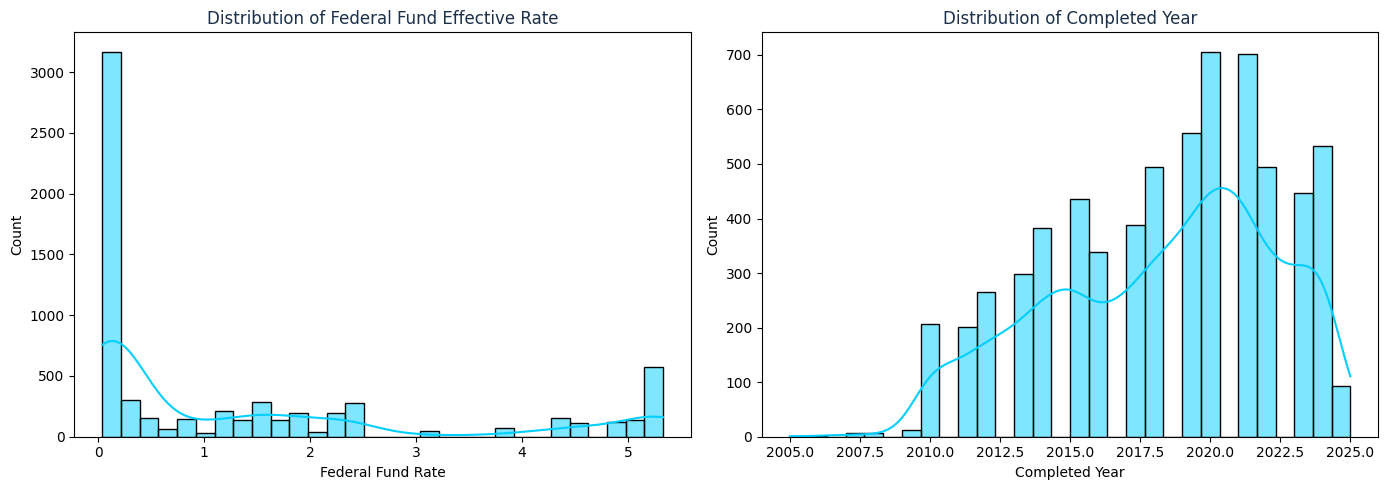

In [182]:
# Accessible palette
palette = {
    "white": "#FFFFFF",
    "light": "#B3EFFF",
    "bright": "#00CFFF",
    "medium": "#046B99",
    "dark": "#1C304A",
    "black": "#000000"
}

# Plot with custom blue
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(
    X_train_encoded['federal_fund_effective_rate'],
    kde=True,
    color=palette["bright"],
    ax=axs[0],
    bins=30
)
axs[0].set_title('Distribution of Federal Fund Effective Rate', color=palette["dark"])
axs[0].set_xlabel('Federal Fund Rate')
axs[0].set_ylabel('Count')

sns.histplot(
    X_train_encoded['completed_year'],
    kde=True,
    color=palette["bright"],
    ax=axs[1],
    bins=30
)
axs[1].set_title('Distribution of Completed Year', color=palette["dark"])
axs[1].set_xlabel('Completed Year')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()



Impute federal_fund_effective_rate and completed_year for train and test set

In [183]:
from sklearn.impute import SimpleImputer

# Create median imputer
imputer = SimpleImputer(strategy='median')

# Apply to both train and test
X_train_encoded[['federal_fund_effective_rate', 'completed_year']] = imputer.fit_transform(
    X_train_encoded[['federal_fund_effective_rate', 'completed_year']]
)

X_test_encoded[['federal_fund_effective_rate', 'completed_year']] = imputer.transform(
    X_test_encoded[['federal_fund_effective_rate', 'completed_year']]
)


Check that missing values are resolved

In [184]:
print(X_train_encoded.isna().sum().sum())
print(X_test_encoded.isna().sum().sum())


0
0


**Impute Missing Values for Y Train and Test Sets**

In [185]:
print(y_train.isna().sum())
print(y_test.isna().sum())


213
84


Random Forest Imputation for amount

In [186]:
# Missing and non-missing masks
missing_train = y_train.isna()
missing_test = y_test.isna()

# Training data for imputer
X_train_imp = X_train_encoded[~missing_train]
y_train_imp = y_train[~missing_train]

# Data that needs imputing
X_train_missing = X_train_encoded[missing_train]
X_test_missing = X_test_encoded[missing_test]


In [187]:
rf_imputer = RandomForestRegressor(n_estimators=100, random_state=42)
rf_imputer.fit(X_train_imp, y_train_imp)


RandomForestRegressor(random_state=42)

In [188]:
# Predict and fill in missing y_train values
y_train_imputed = y_train.copy()
y_train_imputed[missing_train] = rf_imputer.predict(X_train_missing)

# Predict and fill in missing y_test values
y_test_imputed = y_test.copy()
y_test_imputed[missing_test] = rf_imputer.predict(X_test_missing)


In [189]:
# Check
print("Missing in y_train after imputation:", y_train_imputed.isna().sum())
print("Missing in y_test after imputation:", y_test_imputed.isna().sum())


Missing in y_train after imputation: 0
Missing in y_test after imputation: 0


**Preform Arithmetic Transformations**

Apply a log Transformation to amount

In [192]:
# Apply log transformation to amount
y_train_log = np.log1p(y_train_imputed)
y_test_log = np.log1p(y_test_imputed)



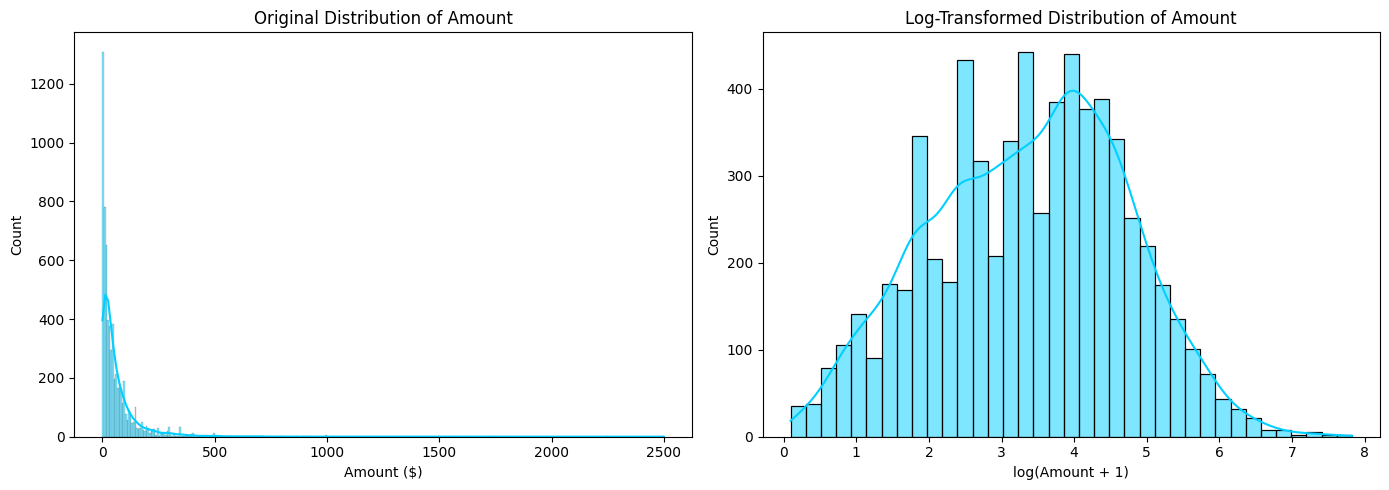

In [193]:
# Accessible palette
blue = '#00CFFF'

# Plot original vs log-transformed y_train
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Original amount distribution
sns.histplot(y_train_imputed, kde=True, color=blue, ax=axs[0])
axs[0].set_title("Original Distribution of Amount")
axs[0].set_xlabel("Amount ($)")

# Log-transformed amount distribution
sns.histplot(np.log1p(y_train_imputed), kde=True, color=blue, ax=axs[1])
axs[1].set_title("Log-Transformed Distribution of Amount")
axs[1].set_xlabel("log(Amount + 1)")

plt.tight_layout()
plt.show()


**Normalize, Center, and/or Scale**

In [203]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


In [204]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns, index=X_train_encoded.index)



In [205]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns, index=X_test_encoded.index)



In [206]:
def plot_scaled_distributions(df, color='#00CFFF', bins=30):
    n = df.shape[1]
    rows = (n // 3) + int(n % 3 > 0)
    fig, axs = plt.subplots(rows, 3, figsize=(18, rows * 4))
    axs = axs.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], kde=True, bins=bins, color=color, ax=axs[i])
        axs[i].set_title(f"{col} (Scaled)")
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


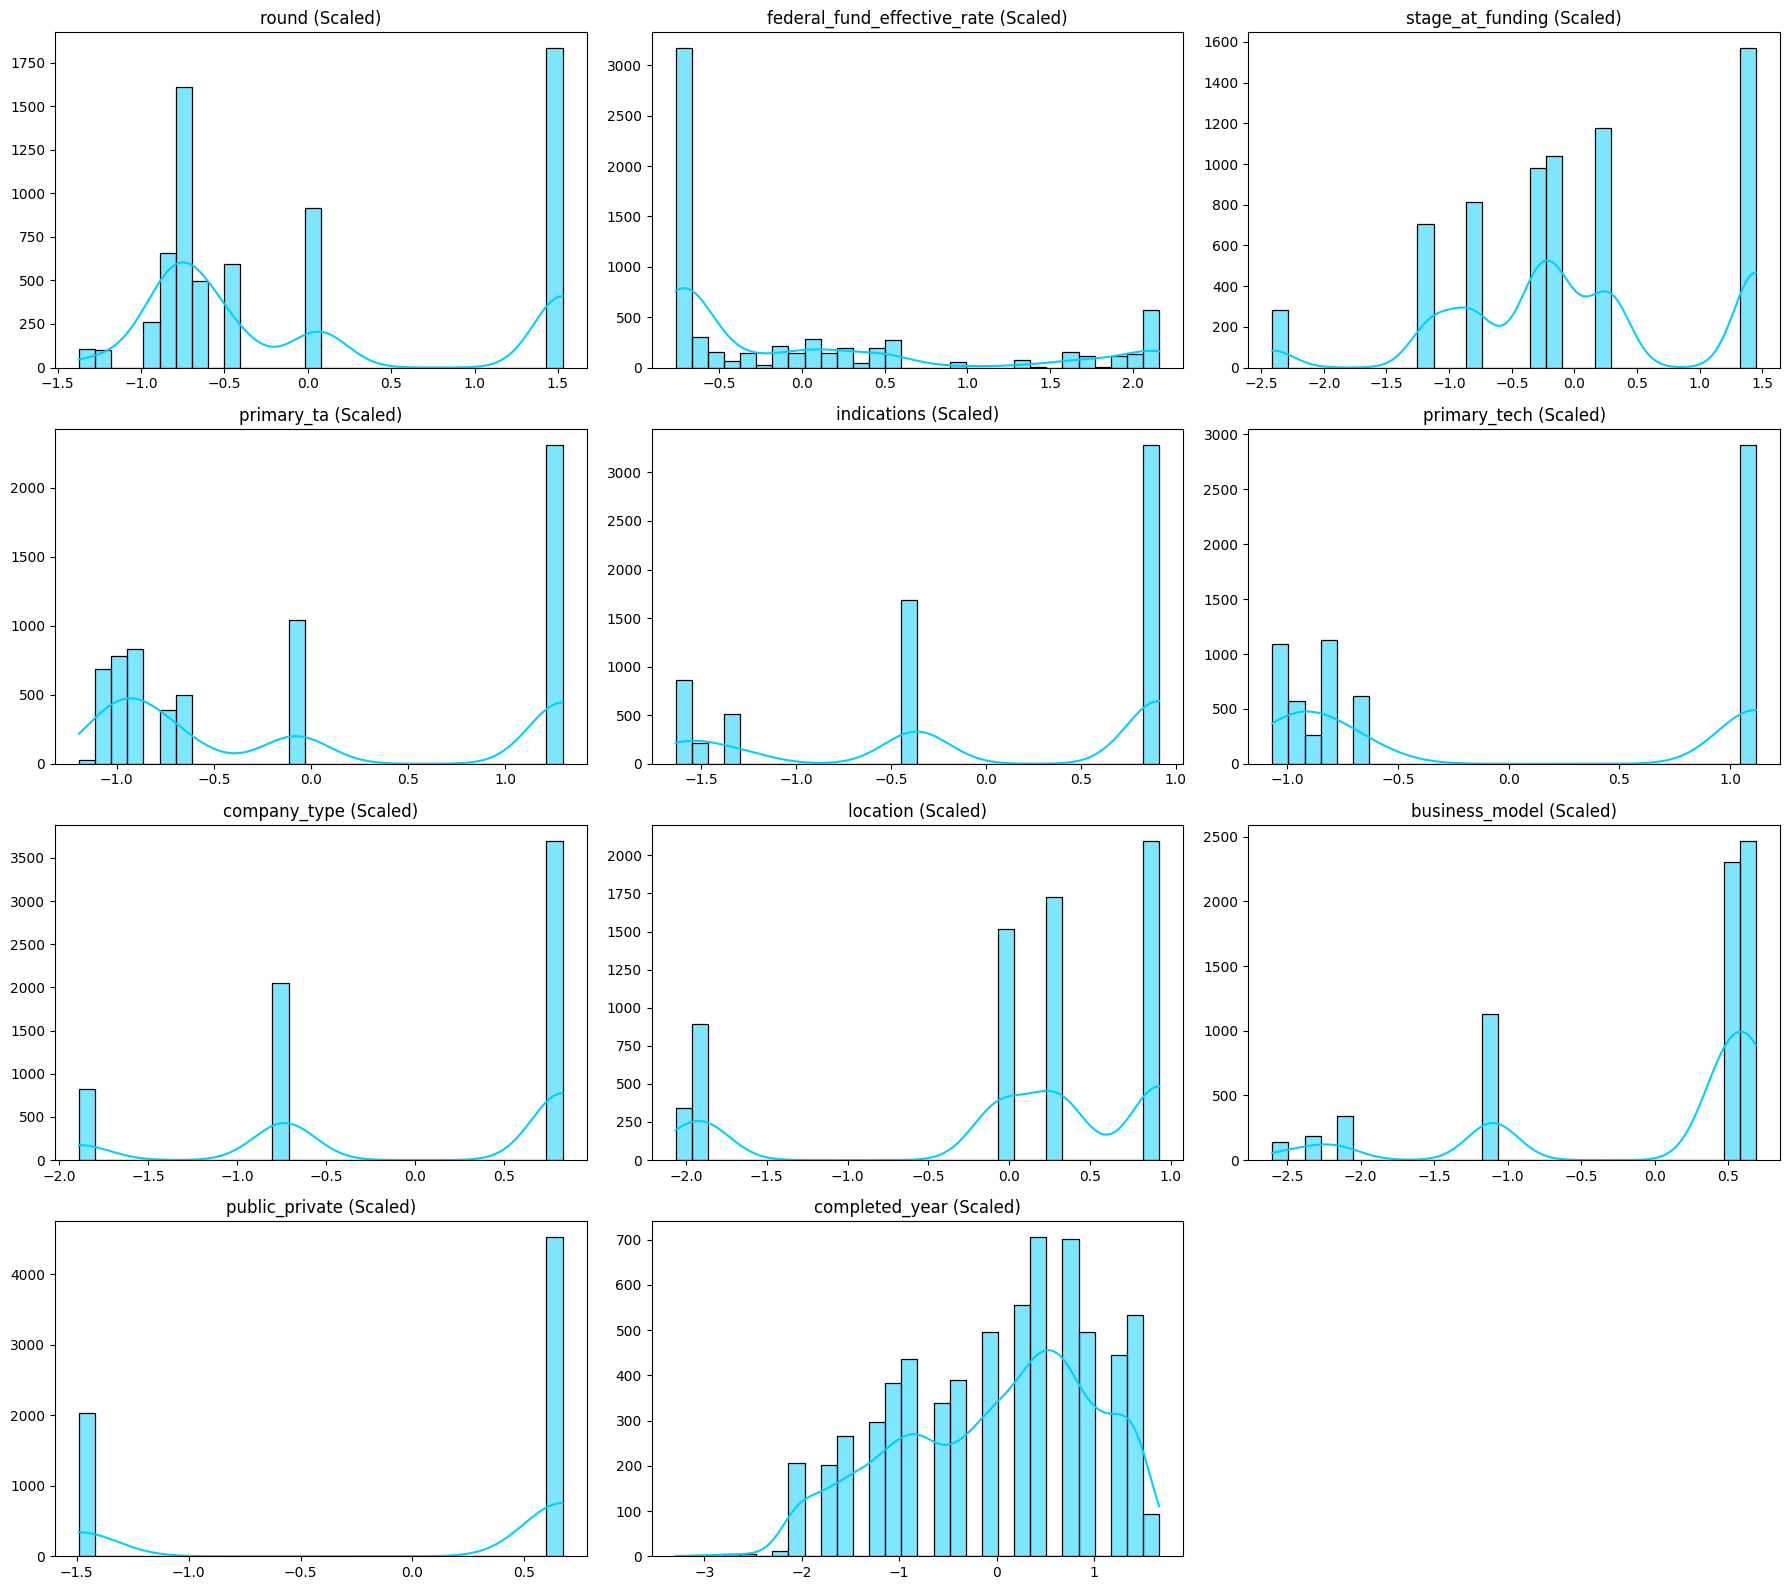

In [207]:
plot_scaled_distributions(X_train_scaled)
